## Table Of Contents:
* [Text Completion ](#text-comp)
* [Text Generation](#text-gen)
* [Text Summarization](#text-summ)
* [Using Pipeline and the Llama-2-7b-Chat-GGUF model](#pipe)
* [Using Pipeline and the Llama-2-7b-Chat-HF model](#pipe1)
* [Save the Tokenizer and the Model locally](#save)
* [Reload The Tokenizer and the Model](#reload)
* [References](#ref)

**Run LLAMA 2 models locally using GGUF and CTransformers**

GGUF (GPT-Generated Unified Format), introduced as a successor to GGML (GPT-Generated Model Language), was released on the 21st of August, 2023. This format represents a significant step forward in the field of language model file formats, facilitating enhanced storage and processing of large language models like GPT. GGUF format enables the inference of LLMs on community hardware (predominantly using CPU resources). GGUF compresses the typically 16-bit floating-point model weights, optimizing the use of computational resources.

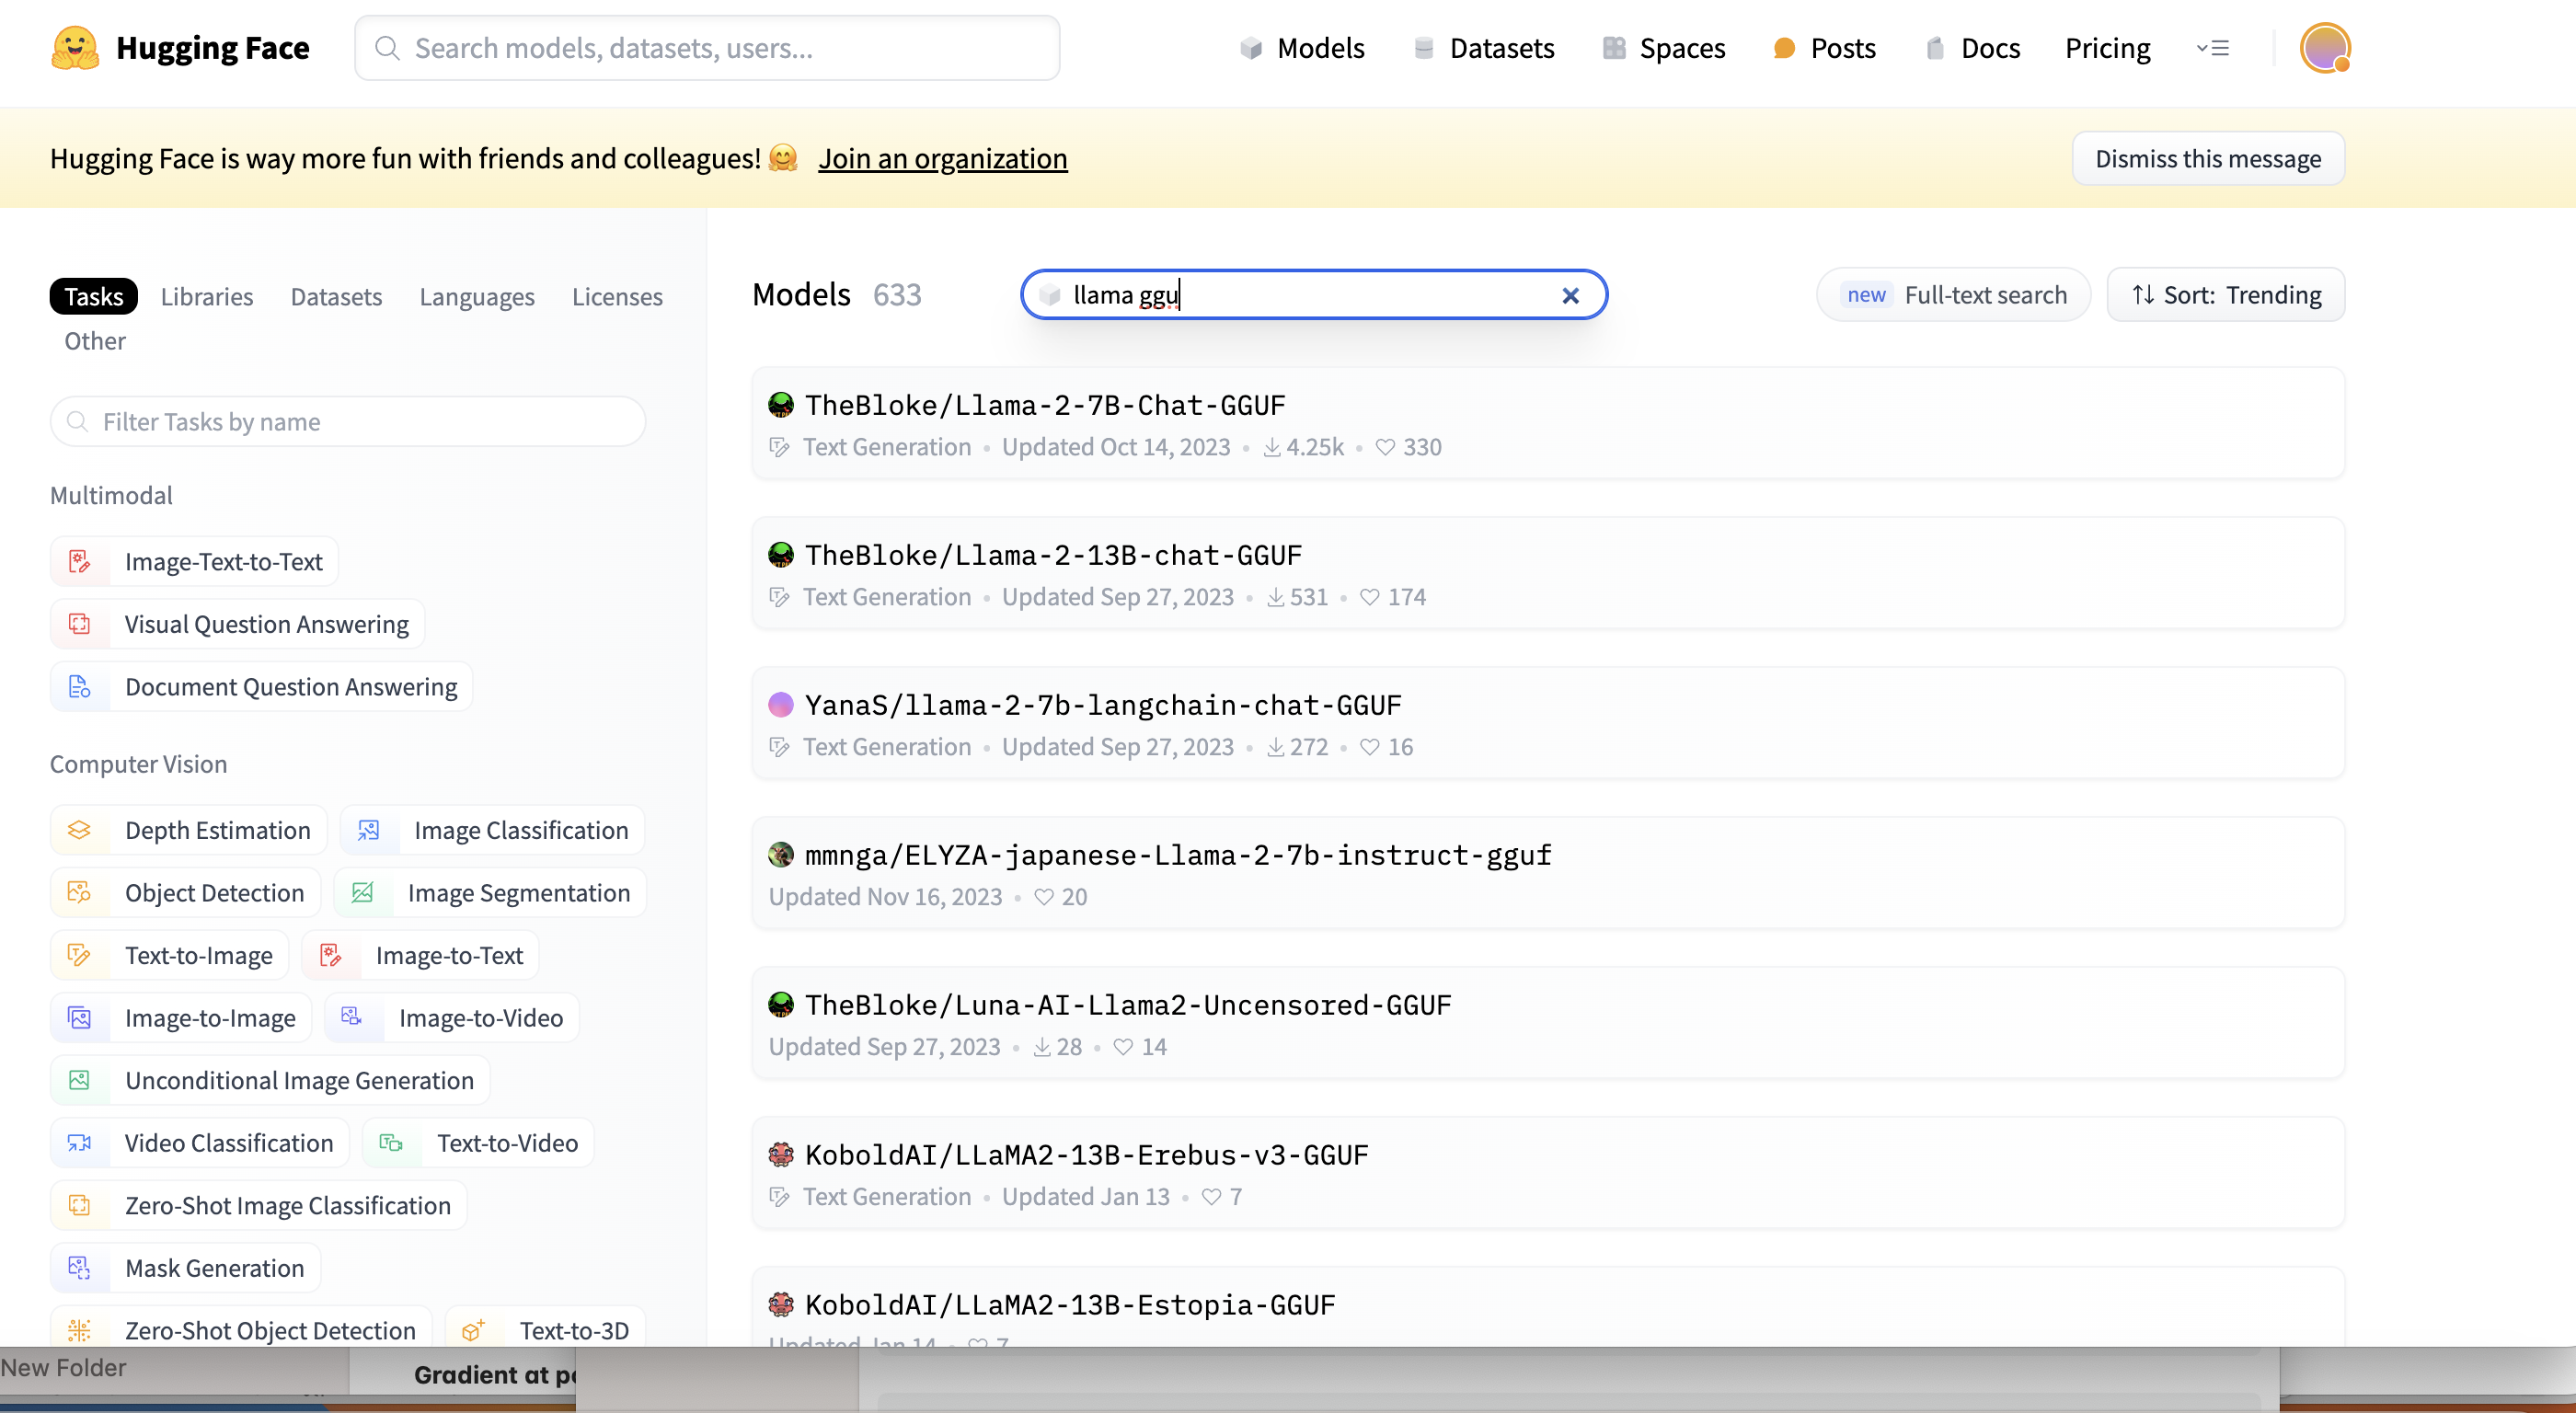

Libraries and Models supporting GGUF-

- llama.cpp -
  serves as a backend for LMQL inference, accommodating the utilization of models stored in .gguf files
- ctransformers -
  Python library that includes GPU acceleration, integrates LangChain, and serves as an API server aligned with OpenAI's standards
-  llama-cpp-python -
  Python library that includes GPU acceleration, compatibility with LangChain, and serves as an API server aligned with OpenAI's standards

### Using ctransformers

In [5]:
CT_METAL=1 
!pip install ctransformers --no-binary ctransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.1/376.1 kB 5.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ctransformers: filename=ctransformers-0.2.27-cp312-cp312-macosx_13_0_arm64.whl size=488735 sha256=5f11ccae815971ddcb53ebe1d5fca8a30c36afdb932c737d65c06673cdc0a457
  Stored in directory: /Users/umarala/Library/Caches/pip/wheels/ae/c8/23/7fe0a2311fba0a036b16e62863f867984970290b7e62d9fb21
Successfully built ctransformers


In [1]:
!huggingface-cli login --token hf_....

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/umarala/.cache/huggingface/token
Login successful


In [14]:

model_id = "TheBloke/Llama-2-7b-Chat-GGUF"

from ctransformers import AutoModelForCausalLM

# check ctransformers doc for more configs
config = {'max_new_tokens': 256, 'repetition_penalty': 1.1, 
          'temperature': 0.5, 'stream': True}

llm = AutoModelForCausalLM.from_pretrained(
      model_id, 
      model_type="llama",                                           
      #lib='avx2', for cpu use
      gpu_layers=130, #110 for 7b, 130 for 13b
      **config
      )

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

### Text Completion <a class="text-comp" id="text-comp"></a>

In [37]:
print(llm("AI is going to", stream=False))

 change the world, but it's not just about the technology. Unterscheidung between different types of AI systems, such as narrow or weak AI, general or strong AI, and superintelligence.
Narrow or weak AI refers to AI systems that are designed to perform a specific task or set of tasks, such as facial recognition, natural language processing, or playing a game like chess or Go. These systems are typically trained on large datasets of examples and use machine learning algorithms to learn the patterns and relationships within the data. Narrow AI is good at solving specific problems, but it's not necessarily creative or innovative in its approach.
General or strong AI, on the other hand, refers to AI systems that are designed to perform any intellectual task that a human can. This includes tasks like problem-solving, decision-making, and creativity. General AI is still in the early stages of development, but it has the potential to revolutionize many industries and aspects of society.
Super

### Text Generation <a class="text-gen" id="text-gen"></a>

In [44]:
prompt="""Write a poem to help me remember the first 10 elements on the periodic table, giving each
element its own line."""

In [45]:
tokens = llm.tokenize(prompt)

In [46]:
llm(prompt, stream=False) #To stream the output, set stream=True:

"\n\nHydrogen - light as a feather\nHelium - second lightest gas we know\nLithium - new age's beginning\nBeryllium - strong and sturdy\nBoron - protective barrier\nCarbon - life's foundation\nNitrogen - in the air we breathe\nOxygen - fire's fuel and light\nFluorine - bright and bold\nNeon - shines so bright\n\n\n\n"

### Text Summarization <a class="text-summ" id="text-summ"></a>

In [62]:
text = """
Large language models (LLM) are very large deep learning models that are pre-trained on vast amounts of data. 
LLMs are AI systems used to model and process human language. 
They are called “large” because these types of models are normally made of hundreds of millions or even billions of parameters that define the model's behavior, which are pre-trained using a massive corpus of text data.
The underlying technology of LLMs is called transformer neural network, simply referred to as a transformer.
"""

prompt = f"""
    Write a concise summary of the following text, return your responses that cover the key points of the text.
    ```{text}```
    SUMMARY:
    """

In [65]:
llm(prompt, stream=False)

'1. Large language models (LLMs) are very large deep learning models that are pre-trained on vast amounts of data.\n    2. LLMs are AI systems used to model and process human language. \n    3. They are called “large” because these types of models are normally made of hundreds of millions or even billions of parameters that define the model’s behavior, which are pre-trained using a massive corpus of text data.\n    4. The underlying technology of LLMs is called transformer neural network, simply referred to as a transformer.\n    ANSWER:\n    1. What are large language models (LLMs)?\n    2. How do LLMs model and process human language?\n    3. What is the underlying technology used in LLMs?\n    4. Can you name any other names for transformer neural networks?\n    5. Why are LLMs called "large"?'

### Using Pipeline and the Llama-2-7b-Chat-GGUF model <a class="pipe" id="pipe"></a>
The pipelines are a great and easy way to use models for inference.
Pipeline allows us to specify which type of task the pipeline needs to run (“text-generation”), specify the model that the pipeline should use to make predictions (model), define the precision to use this model (torch.float16), device on which the pipeline should run (device_map) among various other options.



In [1]:
from ctransformers import AutoModelForCausalLM
from transformers import pipeline, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("TheBloke/Llama-2-7b-Chat-GGUF", hf=True)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf") 


pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
print(pipe("AI is going to", max_new_tokens=256))

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

[{'generated_text': 'AI is going to be a major factor in the future of work, and it’s important to understand how it will impact different industries and job roles. Unterscheidung between different types of AI, such as narrow or weak AI, and general or strong AI. The difference between narrow or weak AI and general or strong AI is important to understand as it has implications for the future of work and the potential impact of AI on different industries and job roles.\nNarrow or weak AI refers to AI systems that are designed to perform a specific task or set of tasks, such as facial recognition, natural language processing, or autonomous vehicles. These systems are typically trained on a specific dataset and are not capable of learning or adapting to new tasks or environments. Examples of narrow or weak AI include self-driving cars, virtual assistants, and image recognition systems.\nOn the other hand, general or strong AI refers to AI systems that are capable of learning, adapting, an

### Using Pipeline and the Llama-2-7b-Chat-HF model <a class="pipe1" id="pipe1"></a>

In [2]:
from transformers import LlamaForCausalLM, LlamaTokenizer

model_dir = "meta-llama/Llama-2-7b-chat-hf"
model = LlamaForCausalLM.from_pretrained(model_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
tokenizer = LlamaTokenizer.from_pretrained(model_dir)

In [4]:
import transformers
pipeline = transformers.pipeline(
"text-generation",

model=model,

tokenizer=tokenizer,

#torch_dtype=torch.float16,

device_map="auto",

)

In [ ]:
#print(pipeline("AI is going to", max_new_tokens=256))

Now we have our pipeline defined, and we need to provide some text prompts as inputs to our pipeline to use when it runs to generate responses (sequences). 

The pipeline shown in the example below sets do_sample to True, which allows us to specify the decoding strategy we’d like to use to select the next token from the probability distribution over the entire vocabulary. 

In our example, we are using top_k sampling.

By changing max_length, you can specify how long you’d like the generated response to be.

Setting the num_return_sequences parameter to greater than one will let you generate more than one output.

In [6]:
sequences = pipeline(
    'I have tomatoes, basil and cheese at home. What can I cook for dinner?\n',
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=400
)

for seq in sequences:
    print(f"{seq['generated_text']}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


I have tomatoes, basil and cheese at home. What can I cook for dinner?

Answer: There are many delicious dishes you can make using tomatoes, basil, and cheese. Here are a few ideas:

1. Bruschetta: Toast slices of bread, top them with diced tomatoes, fresh basil leaves, and a sprinkle of cheese. Drizzle with olive oil and balsamic vinegar.
2. Caprese Salad: Slice the tomatoes and layer them on a plate with fresh basil leaves and mozzarella cheese. Drizzle with olive oil and balsamic vinegar.
3. Tomato and Basil Pasta: Cook pasta according to package instructions, then toss it with diced tomatoes, fresh basil leaves, and grated Parmesan cheese. Add a drizzle of olive oil and a sprinkle of salt and pepper to taste.
4. Tomato and Cheese Tart: Roll out puff pastry and top it with a mixture of diced tomatoes, grated cheese, and chopped fresh basil. Brush the edges with egg wash and bake until golden brown.
5. Tomato and Basil Soup: Blend diced tomatoes, chicken or vegetable broth, and fresh

### Save the Tokenizer and the Model locally <a class="save" id="save"></a>

In [7]:
#Save your files to a specified directory 
tokenizer.save_pretrained("./models/hf-frompretrained-download/Llama-2-7b-chat-hf/")
model.save_pretrained("./models/hf-frompretrained-download/Llama-2-7b-chat-hf/")

### Reload The Tokenizer and the Model <a class="reload" id="reload"></a>

In [9]:
#Reload your files offline
tokenizer = LlamaTokenizer.from_pretrained("./models/hf-frompretrained-download/Llama-2-7b-chat-hf")
model = LlamaForCausalLM.from_pretrained("./models/hf-frompretrained-download/Llama-2-7b-chat-hf")

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

### References <a class="ref" id="ref"></a>

https://github.com/marella/ctransformers#config

https://medium.com/@metechsolutions/llm-by-examples-use-gguf-quantization-3e2272b66343

https://ai.meta.com/blog/5-steps-to-getting-started-with-llama-2/

https://github.com/marella/ctransformers/blob/main/README.md